In [9]:
#DR Techniques:
#PCA
#Independent component analysis(ICA)
#Truncated SVD(TSVD)
#Gaussian Random Projection(GRP)
#Sparse Random Projection(SRP)
#Non-negative Matrix factorization(NMF)
#Feature agglomeration

In [10]:
######Questions:
#XGBoost: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
#sklearn elasticNet? a lasso/ridge hybrid. L1_ratio=0-> ridge, l1_ratio=1-->lasso, between (0,1) is a mix of the two
#Ridge/lasso difference. The only difference from Ridge regression is that the regularization term is in absolute value. ... 
#Lasso method overcomes the disadvantage of Ridge regression by not only punishing high values of the coefficients β 
#but actually setting them to zero if they are not relevant.
#Outlier detection: Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier. But in here we are not using such rule and why?
#combinations: create all possible combinations from list or set
#how to inteprest pca results such as pca1, pca2?
#random state meaning?  used for initializing the internal random number generator, which will decide the splitting of data into train and test indices in your case.
#how to get c-score from model? Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0

In [11]:
#PCA: DR using singular value decomposition of data to project it to lower diemensional space. input data is centered but not scaled before applying SVD
#this class does not support sparse data(most of the cells being empty or NA)

#Truncated SVD(TSVD): compared to PCA, this estimator does not center the data before computing the singalar value decomposition. it can work with 
#scipy.sparse matrix efficiently. 2 possible algorithms: a fast randomized SVD solver, and a naive algorithm that uses an eigensolver on (X*X.T) or (X.T*X)

##Gaussian Random Projection(GRP):
#reduce dimensionality throug gaussian random projection. Components of random matrix are drawn from N(0,1/n_components)

#Sparse Random Projection(SRP):
#reduce dimensionality throug sparse random projection. 

#Feature agglomeration
#Similar to agglomerativeClustering, but recursively merges features instead of samples. 

In [37]:
import pandas as pd
import numpy as np
import random
from itertools import combinations
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
#import lightgbm as lgb


from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA,FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import FeatureAgglomeration
from sklearn import tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle

import warnings
warnings.filterwarnings('ignore')

random.seed(1729)

In [18]:
#load and prepare data
%cd '/Users/xiaoyingliu/desktop/MB'

/Users/xiaoyingliu/Desktop/MB


In [17]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
#removing the outlier:
train=train.loc[train['y']<170,:]
#seperating labels and features:
y_train=train['y']
train=train.drop('y',axis=1)
#label encoding the categorical features for dimension reduction
for c in train.columns:
    if train[c].dtype=='object':
        lbl=LabelEncoder()
        lbl.fit(list(train[c].values)+list(test[c].values))
        train[c]=lbl.transform(list(train[c].values))
        test[c]=lbl.transform(list(test[c].values))

In [19]:
#Creating components using various DR techniques
n_comp=12
#TSVD
tsvd=TruncatedSVD(n_components=n_comp,random_state=420)
tsvd_results_train=tsvd.fit_transform(train)
tsvd_results_test=tsvd.transform(test)

#PCA
pca=PCA(n_components=n_comp,random_state=420) #create a pca object
pca2_results_train=pca.fit_transform(train)# then apply the object to fit_transform training set/transfrom test set
pca2_results_test=pca.transform(test)

#ICA
ica=FastICA(n_components=n_comp,random_state=420)
ica2_results_train=ica.fit_transform(train)
ica2_results_test=ica.transform(train)

#GRP
grp=GaussianRandomProjection(n_components=n_comp,eps=0.1, random_state=420)
grp_results_train=grp.fit_transform(train)
grp_results_test=grp.transform(train)

#SRP
srp=SparseRandomProjection(n_components=n_comp,dense_output=True, random_state=420)
srp_results_train=srp.fit_transform(train)
srp_results_test=srp.transform(train)

#NMF
nmf=NMF(n_components=n_comp,init='nndsvdar', random_state=420)
nmf_results_train=nmf.fit_transform(train)
nmf_results_test=nmf.transform(train)

#FAG
fag=FeatureAgglomeration(n_clusters=n_comp,linkage='ward')
fag_results_train=fag.fit_transform(train)
fag_results_test=fag.transform(train)

In [20]:
#Filtering the most significant components and inserting a DataFrame
dim_reds = list()
train_pca = pd.DataFrame()
test_pca = pd.DataFrame()

train_ica = pd.DataFrame()
test_ica = pd.DataFrame()

train_tsvd = pd.DataFrame()
test_tsvd = pd.DataFrame()

train_grp = pd.DataFrame()
test_grp = pd.DataFrame()

train_srp = pd.DataFrame()
test_srp = pd.DataFrame()

train_nmf = pd.DataFrame()
test_nmf = pd.DataFrame()

train_fag = pd.DataFrame()
test_fag = pd.DataFrame()


for i in range(1, n_comp + 1):
    train_pca['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test_pca['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train_ica['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test_ica['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train_tsvd['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test_tsvd['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train_grp['grp_' + str(i)] = grp_results_train[:, i - 1]
    test_grp['grp_' + str(i)] = grp_results_test[:, i - 1]

    train_srp['srp_' + str(i)] = srp_results_train[:, i - 1]
    test_srp['srp_' + str(i)] = srp_results_test[:, i - 1]
    
    train_nmf['nmf_' + str(i)] = nmf_results_train[:, i - 1]
    test_nmf['nmf_' + str(i)] = nmf_results_test[:, i - 1]
    
    train_fag['fag_' + str(i)] = fag_results_train[:, i - 1]
    test_fag['fag_' + str(i)] = fag_results_test[:, i - 1]
    
dim_reds.append(('pca', train_pca, test_pca))
dim_reds.append(('ica', train_ica, test_ica))
dim_reds.append(('tsvd', train_tsvd, test_tsvd))
dim_reds.append(('grp', train_grp, test_grp))
dim_reds.append(('srp', train_srp, test_srp))
dim_reds.append(('nmf', train_nmf, test_nmf))
dim_reds.append(('fag', train_fag, test_fag))

In [21]:
dim_reds

[('pca',
              pca_1      pca_2      pca_3      pca_4      pca_5      pca_6  \
  0    -4206.496934  -0.004169  -0.040700  13.251230  -4.374623 -21.241295   
  1    -4200.488489  -0.062182   1.778654  11.436857  -5.129672 -25.175338   
  2    -4199.490590  16.463287  13.810357  11.673968 -15.110398 -23.034331   
  3    -4197.491940  16.415288  14.793977   7.402465   3.435350 -25.485340   
  4    -4193.528315  16.833193  14.091917  10.236943  -3.105061  -8.539142   
  5    -4188.537094 -10.684781  10.379502  -4.467649  -7.923596  -6.451516   
  6    -4182.532250  25.923247   1.941920   4.196089  -7.980194  -6.002052   
  7    -4181.535451  -5.393802   0.299919   3.789510  11.052234  -8.057887   
  8    -4179.533726 -11.691962   1.824157  12.722551   4.851542  -7.146882   
  9    -4176.537560  -3.419565  -3.070343  -6.830757   6.474160  -7.541478   
  10   -4175.535342   7.226574  20.197590   8.049517  -4.976410  -6.037135   
  11   -4174.532350  26.047590   2.146871   3.895592  -

In [32]:
#Creating combinations and running models on them
combs = [combinations(dim_reds, i+1) for i in range(0, len(dim_reds))]

dr_scores = list()
for c1 in combs:
    for c2 in c1:   
        train_, test_, id_ = list(), list(), list()
        for k in c2:
            train_.append(k[1])
            test_.append(k[2])
            id_.append(k[0])
               
        train_x = train.reset_index(drop=True)
        train_.append(train_x)
        test_.append(test)
            
        train_ = pd.concat(train_, axis=1)
        test_ = pd.concat(test_, axis=1)
            

In [63]:
#training and scoring the models with a particular combination
#DecisionTree Model
model=sklearn.tree.DecisionTreeRegressor(max_depth=3,min_samples_split=11,presort=False,random_state=1729)
model.fit(train_,y_train)
c_score=r2_score(y_train,model.predict(train_))
#c_score=0.6
dr_scores.append((','.join(id_), c_score))

#ElasticNet Model
model=ElasticNet(alpha=0.014,tol=0.11,l1_ratio=0.99999999,normalize=True,fit_intercept=False, warm_start=True,
                copy_X=True,precompute=False, positive=False, max_iter=60)
model.fit(train_,y_train)
c_score=r2_score(y_train,model.predict(train_))
full_score=c_score
dr_scores.append((','.join(id_), c_score))
#0.5847

In [64]:
#Ridge model
model=Ridge()
model.fit(train_,y_train)
c_score=r2_score(y_train,model.predict(train_))
dr_scores.append((','.join(id_), c_score))
#0.6198

In [65]:
#xgboost model
xgb_params={
    'n_trees':520,
    'eta':0.0045,
    'max_depth':4,
    'subsample':0.93,
    'objective':'reg:squarederror',
    'eval_metric': 'rmse',
    'base_score': np.mean(y_train),
}
dtrain=xgb.DMatrix(train_,y_train)

num_boost_rounds=1250
model=xgb.train(xgb_params,dtrain,num_boost_round=num_boost_rounds)
c_score=r2_score(y_train,model.predict(dtrain))
dr_scores.append((','.join(id_), c_score))
#0.6880

In [66]:
#use ElasticNet c_score as baseline named full_score
dr_scores.append(('baseline', full_score))

In [67]:
dr_scores

[('pca,ica,tsvd,grp,srp,nmf,fag', 0.6879968114030333),
 ('baseline', 0.5847603094406117),
 ('pca,ica,tsvd,grp,srp,nmf,fag', 0.6024041072895316),
 ('pca,ica,tsvd,grp,srp,nmf,fag', 0.5847603094406117),
 ('pca,ica,tsvd,grp,srp,nmf,fag', 0.6197667349291711),
 ('pca,ica,tsvd,grp,srp,nmf,fag', 0.6879968114030333),
 ('baseline', 0.5847603094406117)]

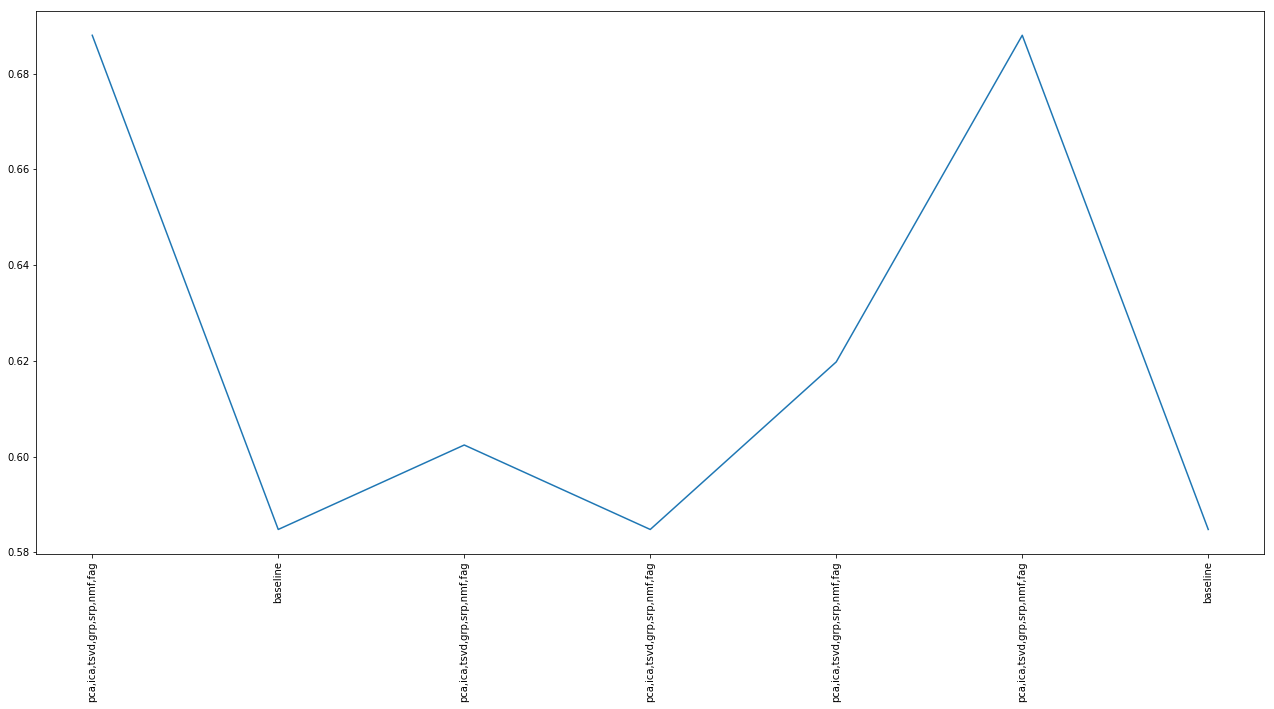

In [68]:
#Plotting graph
x_axis = [c[0] for c in dr_scores]
y_axis = [c[1] for c in dr_scores]
fig, ax = plt.subplots(figsize=(22, 10))
plt.plot(y_axis)
ax.set_xticks(range(len(x_axis)))
ax.set_xticklabels(x_axis, rotation='vertical')
plt.show()

In [69]:
#conclusion
sorted_id=np.argsort(y_axis)
print('\n\nBest Score: {}'.format(np.array(x_axis)[sorted_id[-1]]))
#So pca and ica are playing the mean role



Best Score: pca,ica,tsvd,grp,srp,nmf,fag
